# Extracción de datos de WaveWatch3, por regiones y períodos

Emilio Mayorga, 2022-8-19

Datos de WW3 extraídos del servidor de ERDDAP de NOAA Coastwatch. Este notebook extrae datos multidimensionales basados en la región geográfica (bounding box) y período especificados. Actualmente incluye regiones entre Estados Unidos y México (San Diego a Ensenada) y Ecuador y Perú. El notebook en estos momentos no exporta los datos extraídos a un archivo, pero sería fácil exportarlo a netcdf.

Apuntes
- Página del dataset en el ERDDAP de Coastwatch: https://coastwatch.pfeg.noaa.gov/erddap/griddap/NWW3_Global_Best.html
- La longitud de estos datos está en el formato 0 a 360 en vez de -180 a +180
- El sitio http://bboxfinder.com es muy útil para escoger el bounding box de cada región

```python
# Este funciona perfectamente
ds = xr.open_dataset("https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalDailyP05")

# Esto deberia de funcionar, pero no funciona
ds = xr.open_dataset("https://coastwatch.pfeg.noaa.gov/erddap/griddap/NWW3_Global_Best")
```

In [24]:
import datetime
import json

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from erddapy import ERDDAP

In [2]:
e = ERDDAP(
    server="CSWC",  # CoastWatch West Coast Node
    protocol="griddap",  # Protocol for gridded datasets
)

e.dataset_id = "NWW3_Global_Best" 

In [3]:
e.griddap_initialize()

In [4]:
print(f"variables in this dataset:\n\n{e.variables}")
print(
    f"\nconstraints of this dataset:\n\n{json.dumps(e.constraints, indent=1)}"
)

variables in this dataset:

['Tdir', 'Tper', 'Thgt', 'sdir', 'sper', 'shgt', 'wdir', 'wper', 'whgt']

constraints of this dataset:

{
 "time>=": "2022-08-25T18:00:00Z",
 "time<=": "2022-08-25T18:00:00Z",
 "time_step": 1,
 "depth>=": 0.0,
 "depth<=": 0.0,
 "depth_step": 1,
 "latitude>=": -77.5,
 "latitude<=": 77.5,
 "latitude_step": 1,
 "longitude>=": 0.0,
 "longitude<=": 359.5,
 "longitude_step": 1
}


Especifiquemos que variables vamos a obtener de ERDDAP, para no lidiar con todas

In [5]:
e.variables = ['shgt', 'Thgt']

Especifiquemos el periodo temporal que usaremos en común en las dos regiones

Por ahora vamos a enfocarnos en el año 2020

In [6]:
dt_comienzo = datetime.datetime(2020, 1, 1)
dt_final = datetime.datetime(2020, 12, 31)

In [7]:
e.constraints.update(
    {
        "time>=": f"{dt_comienzo}Z", # "2021-08-1 00:00:00Z",
        "time<=": f"{dt_final}Z", # "2021-08-31 23:00:00Z",
    }
)

In [8]:
def bounds2contraints(bounds):
    return {
        "longitude>=": bounds[0] + 360,
        "longitude<=": bounds[2] + 360,
        "latitude>=": bounds[1],
        "latitude<=": bounds[3],
    }

## Mexico - USA/California

In [9]:
mexusa_bounding_box = [-117.5, 31.5, -116.5, 33]

In [11]:
#e_mexusa = e.copy()
e_mexusa = e

In [12]:
e_mexusa.constraints.update(bounds2contraints(mexusa_bounding_box))

Ahora sí ya tenemos listas todas las constraints y variables que vamos a bajar

In [13]:
e_mexusa.constraints

{'time>=': '2020-01-01 00:00:00Z',
 'time<=': '2020-12-31 00:00:00Z',
 'time_step': 1,
 'depth>=': 0.0,
 'depth<=': 0.0,
 'depth_step': 1,
 'latitude>=': 31.5,
 'latitude<=': 33,
 'latitude_step': 1,
 'longitude>=': 242.5,
 'longitude<=': 243.5,
 'longitude_step': 1}

In [14]:
e_mexusa.variables

['shgt', 'Thgt']

In [15]:
%%time

ds_mexusa = e_mexusa.to_xarray()

CPU times: user 197 ms, sys: 13.2 ms, total: 210 ms
Wall time: 4min 39s


In [16]:
ds_mexusa

<xarray.Dataset>
Dimensions:    (time: 8761, depth: 1, latitude: 4, longitude: 3)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31
  * depth      (depth) float32 0.0
  * latitude   (latitude) float32 31.5 32.0 32.5 33.0
  * longitude  (longitude) float32 242.5 243.0 243.5
Data variables:
    shgt       (time, depth, latitude, longitude) float32 ...
    Thgt       (time, depth, latitude, longitude) float32 ...
Attributes: (12/68)
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    acknowledgement:               The Pacific Islands Ocean Observing System...
    cdm_data_type:                 Grid
    comment:                       Model runs produced by Kwok Fai Cheung (ch...
    Conventions:                   CF-1.6, ACDD-1.3
    creator_email:                 cheung@hawaii.edu
    ...                            ...
    testOutOfDate:                 now+105hours
    time_coverage_end:             2020-12-31T00:00:00Z
    time_coverage_resolution:      PT1H
    time_coverage_start:           2020-01-01T00:00:00Z
    title:                         WaveWatch III (WW3) Global Wave Model
    Westernmost_Easting:           242.5

Un plot geografico en uno de los time steps, mostrando la costa como referencia.

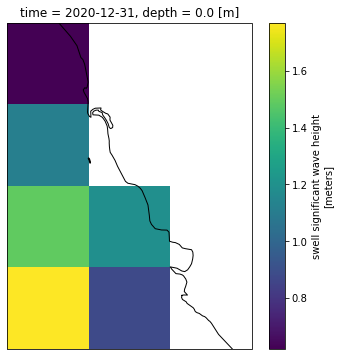

In [25]:
fig, ax = plt.subplots(
    figsize=(6, 6), subplot_kw={"projection": ccrs.PlateCarree()},
)

ds_mexusa.shgt.isel(time=-1).plot(ax=ax)

ax.coastlines();

Un plot de la serie temporal en un pixel

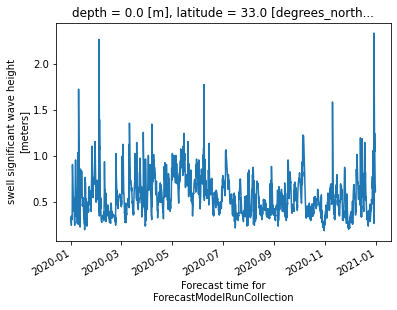

In [18]:
ds_mexusa.shgt.sel(latitude=33, longitude=242.4, method='nearest').plot();

## Peru - Ecuador

In [19]:
ecper_bounding_box = [-82.5, -5, -80, -2]

In [20]:
e_ecper = e

In [21]:
e_ecper.constraints.update(bounds2contraints(ecper_bounding_box))

No logré correr exitosamente un año entero para esta región, así que 6 meses

In [26]:
dt_comienzo_ecper = datetime.datetime(2020, 6, 1)
dt_final_ecper = datetime.datetime(2020, 12, 31)

In [27]:
e_ecper.constraints.update(
    {
        "time>=": f"{dt_comienzo_ecper}Z", # "2021-08-1 00:00:00Z",
        "time<=": f"{dt_final_ecper}Z", # "2021-08-31 23:00:00Z",
    }
)

Ahora sí ya tenemos listas todas las constraints y variables que vamos a bajar

In [28]:
e_ecper.constraints

{'time>=': '2020-06-01 00:00:00Z',
 'time<=': '2020-12-31 00:00:00Z',
 'time_step': 1,
 'depth>=': 0.0,
 'depth<=': 0.0,
 'depth_step': 1,
 'latitude>=': -5,
 'latitude<=': -2,
 'latitude_step': 1,
 'longitude>=': 277.5,
 'longitude<=': 280,
 'longitude_step': 1}

In [29]:
%%time

ds_ecper = e_ecper.to_xarray()

CPU times: user 53.9 ms, sys: 2.63 ms, total: 56.6 ms
Wall time: 2.71 s


In [30]:
ds_ecper

<xarray.Dataset>
Dimensions:    (time: 5113, depth: 1, latitude: 7, longitude: 6)
Coordinates:
  * time       (time) datetime64[ns] 2020-06-01 ... 2020-12-31
  * depth      (depth) float32 0.0
  * latitude   (latitude) float32 -5.0 -4.5 -4.0 -3.5 -3.0 -2.5 -2.0
  * longitude  (longitude) float32 277.5 278.0 278.5 279.0 279.5 280.0
Data variables:
    shgt       (time, depth, latitude, longitude) float32 ...
    Thgt       (time, depth, latitude, longitude) float32 ...
Attributes: (12/68)
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    acknowledgement:               The Pacific Islands Ocean Observing System...
    cdm_data_type:                 Grid
    comment:                       Model runs produced by Kwok Fai Cheung (ch...
    Conventions:                   CF-1.6, ACDD-1.3
    creator_email:                 cheung@hawaii.edu
    ...                            ...
    testOutOfDate:                 now+105hours
    time_coverage_end:             2020-12-31T00:00:00Z
    time_coverage_resolution:      PT1H
    time_coverage_start:           2020-06-01T00:00:00Z
    title:                         WaveWatch III (WW3) Global Wave Model
    Westernmost_Easting:           277.5

Un plot geografico en uno de los time steps, mostrando la costa como referencia.

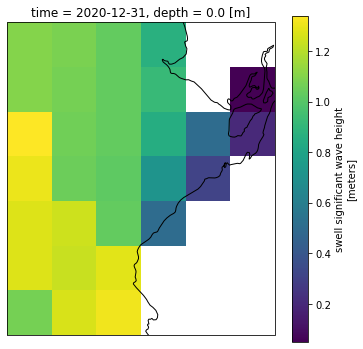

In [35]:
fig, ax = plt.subplots(
    figsize=(6, 6), subplot_kw={"projection": ccrs.PlateCarree()},
)

ds_ecper.shgt.isel(time=-1).plot(ax=ax)

ax.coastlines();

Un plot de la serie temporal en un pixel

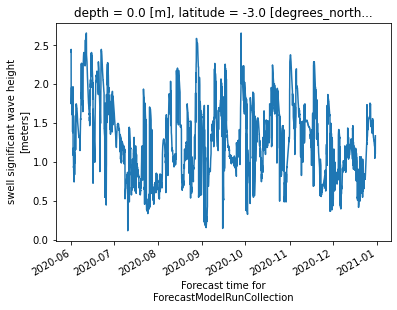

In [32]:
ds_ecper.shgt.sel(latitude=-3, longitude=277, method='nearest').plot();